# Context and Objectives


**Context**

As part of the House Intelligence Committee investigation into how Russia may have influenced the 2016 US Election, Twitter released the screen names of almost 3,000 Twitter accounts believed to be connected to Russia’s Internet Research Agency, a company known for operating social media troll accounts. Twitter immediately suspended these accounts, deleting their data from Twitter.com and the Twitter API. A team at NBC News including Ben Popken and EJ Fox was able to reconstruct a dataset consisting of a subset of the deleted data for their investigation and were able to show how these troll accounts went on the attack during key election moments. This dataset is the body of this open-sourced reconstruction.

For more background, read the NBC news article publicizing the release: "Twitter deleted 200,000 Russian troll tweets. Read them here."

**Content**

This dataset contains two CSV files. tweets.csv includes details on individual tweets, while users.csv includes details on individual accounts. The files can be joined by the filed “user_id” on the tweets.csv file and “id” on the “users.csv” file.

**Guidelines**
In your solution, we care about the following:
1. Data Science process (a small part of the real world process):

a. Exploratory data analysis (EDA).
b. Clean and prepare the data.
c. Feature engineering.
d. Model evaluation.
e. Model/features explainability.
    
2. Organized code - OOP is an option but not a must, functions and clear code flow/structure will be great as well.
3. Versatility/depth  - how deep or how versatile is your solution. Don’t try to demonstrate both, the timeframe you have is not long enough. 
4. Any tool, algorithm, or technique used, will need to be explained.



**Questions** 
1. What are the characteristics of fake tweets? 
    a. Can you describe fake tweets topics?
    b. Can you recognize the emotions in those fake tweets?
    c. Can you understand the user’s networks involved (if any) in those fake tweets?
2. Are the fake tweets distinguishable from real ones? If yes, please build a supervised/unsupervised model which distinguishes between them. (you can enrich the dataset with real tweets - not a must).
    a. Can you leverage the knowledge/ features/ topics from the first question?

**Bonus**:

Can you predict ahead of time when fake tweets are going to peak? 

**Expected Artifacts**

One or more of the following file types with the solution code and outputs (charts, tables, visualization, etc.):
1. Python files
2. Jupyter notebooks files
3. Text files
4. Docker files
5. .README files

# Packages 

In [59]:
import pandas as pd
import numpy as np
import re
from gensim import utils
import gensim.parsing.preprocessing as gsp

from collections import Counter
from collections import defaultdict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from datetime import datetime

from time import time
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.manifold import TSNE

import pyLDAvis
import pyLDAvis.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import networkx as nx

# Import Data

In [2]:
df_user = pd.read_csv('users.csv')
df_twett = pd.read_csv('tweets.csv')

## Users dataset

In [3]:
df_user.head(10)

id                       location              name  \
0  1.871082e+07  near Utah Ave & Lighthouse an    Robby Delaware   
1  1.003451e+08  still ⬆️Block⤵️Corner⬇️street  #Ezekiel2517✨...   
2  2.471657e+08                    Chicago, IL  B E C K S T E R✨   
3  2.495389e+08                            NaN     Chris Osborne   
4  4.496897e+08                            NaN    Рамзан Кадыров   
5  4.718689e+08        Санкт-Петербург, Россия   Маргарита Саваж   
6  1.039581e+09                        Amerika        Dark Nally   
7  1.510489e+09                            USA       Laila Heats   
8  1.513801e+09                            USA           CC Jack   
9  1.517679e+09               Philadelphia, PA          Mr Moran   

   followers_count  statuses_count                    time_zone verified lang  \
0            304.0         11484.0   Pacific Time (US & Canada)    False   en   
1           1053.0         31858.0                          NaN    False   en   
2            650.0          6742.0  Mountain Time (US & Canada)    False   en   
3             44.0           843.0                          NaN    False   en   
4          94773.0         10877.0                       Moscow    False   ru   
5          23305.0         18401.0                    Volgograd    False   ru   
6             22.0         22603.0                      Jakarta    False   id   
7           3080.0          2228.0   Eastern Time (US & Canada)    False   en   
8           2760.0          2100.0   Eastern Time (US & Canada)    False   en   
9            879.0          2044.0   Eastern Time (US & Canada)    False   en   

     screen_name                                        description  \
0  RobbyDelaware  I support the free movement of people, ideas a...   
1    SCOTTGOHARD  CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...   
2    Beckster319  Rebecca Lynn Hirschfeld Actress.Model.Writer.A...   
3  skatewake1994                                                NaN   
4  KadirovRussia  Пародийный аккаунт. Озвучиваю то, что политика...   
5    MargoSavazh                   Честь имею. Нагло врать не умею.   
6      darknally                                  uptodate news!!!!   
7      lagonehoe       How can you judge me when you don’t know me?   
8   YouJustCtrlC  ProBlack | Stoner | even jesus was stoned befo...   
9       MrMoraan  I'm getting too cool for this social media shi...   

                       created_at  favourites_count  friends_count  \
0  Wed Jan 07 04:38:02 +0000 2009              17.0          670.0   
1  Tue Dec 29 23:15:22 +0000 2009            2774.0         1055.0   
2  Fri Feb 04 06:38:45 +0000 2011            7273.0          896.0   
3  Wed Feb 09 07:38:44 +0000 2011             227.0          154.0   
4  Thu Dec 29 11:31:09 +0000 2011               0.0            7.0   
5  Mon Jan 23 10:26:25 +0000 2012            1480.0         8021.0   
6  Thu Dec 27 13:06:58 +0000 2012               0.0           40.0   
7  Wed Jun 12 13:07:49 +0000 2013            3504.0         2369.0   
8  Thu Jun 13 16:07:23 +0000 2013            2744.0         2700.0   
9  Fri Jun 14 21:58:48 +0000 2013            2981.0          758.0   

   listed_count  
0          13.0  
1          35.0  
2          30.0  
3           1.0  
4         691.0  
5         231.0  
6          16.0  
7          12.0  
8          10.0  
9          15.0

In [4]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                393 non-null    float64
 1   location          285 non-null    object 
 2   name              384 non-null    object 
 3   followers_count   384 non-null    float64
 4   statuses_count    384 non-null    float64
 5   time_zone         369 non-null    object 
 6   verified          384 non-null    object 
 7   lang              384 non-null    object 
 8   screen_name       454 non-null    object 
 9   description       339 non-null    object 
 10  created_at        384 non-null    object 
 11  favourites_count  384 non-null    float64
 12  friends_count     384 non-null    float64
 13  listed_count      384 non-null    float64
dtypes: float64(6), object(8)
memory usage: 49.8+ KB


We notice that many variables have **missing value** only the variable 'screen_name' is entirely filled.

An important fact is we **don't have all the ids**.

For each type of data we are going to handle those missing values with a specific solution then look at the data for EDA.

### NaN values

#### Numeric data

In [5]:
df_user.describe()

id  followers_count  statuses_count  favourites_count  \
count  3.930000e+02       384.000000      384.000000        384.000000   
mean   6.982260e+16      4730.726562     4649.156250       1747.578125   
std    2.169368e+17     10415.236197     8522.484132       2583.843375   
min    1.871082e+07         0.000000        1.000000          0.000000   
25%    1.681425e+09       674.000000     1135.000000        230.750000   
50%    2.533222e+09      1468.000000     1732.500000       1277.500000   
75%    2.882037e+09      2820.750000     3012.750000       2196.750000   
max    7.892661e+17     98412.000000    61735.000000      27181.000000   

       friends_count  listed_count  
count     384.000000    384.000000  
mean     2334.039062     38.177083  
std      3524.839198     74.507538  
min         0.000000      0.000000  
25%       402.000000      4.000000  
50%      1027.500000     13.000000  
75%      2667.500000     32.000000  
max     25600.000000    691.000000

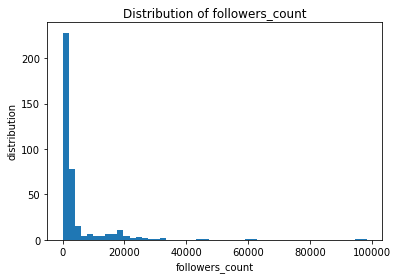

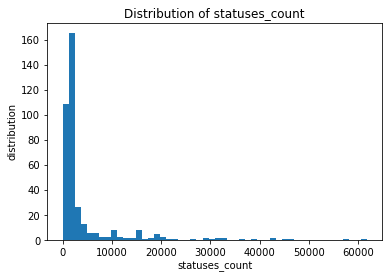

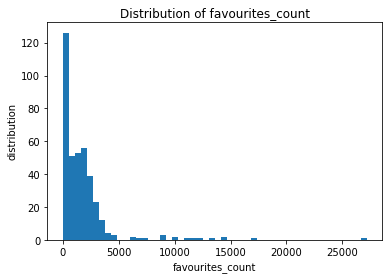

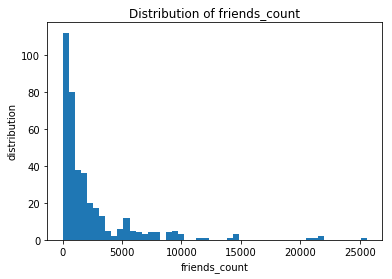

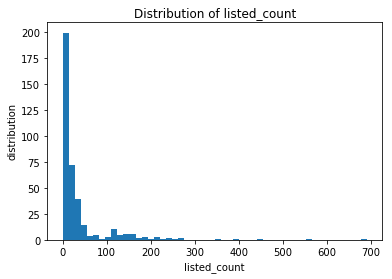

In [6]:
for var in ['followers_count', 'statuses_count', 'favourites_count', 'friends_count', 'listed_count']:
    
    df_user[var].plot.hist(bins=50)
    plt.title('Distribution of '+ var)
    plt.xlabel(var)
    plt.ylabel('distribution')
    plt.show()

For the numeric data we are **filling the missing values with their median** because the distributions are skewed to the right thus replacing by the mean will modify too much the relations.

In [3]:
for var in ['followers_count', 'statuses_count', 'favourites_count', 'friends_count', 'listed_count']:
    df_user[var].fillna(df_user[var].median(), inplace=True)

#### Categorical variables

In [4]:
print(df_user.verified.value_counts())
df_user.drop(['verified'], axis=1, inplace=True)

False    384
Name: verified, dtype: int64


We notice that the variable **'verified'** is either majoritary False or missing thus drop this colunm will not change any of discriminant analysises.

For the others categorical variables we will replace their **missing values by the value 'unknown'**. However we can from here use the other variables to predict those missing. For exemple, predict the location with the language abd the time zone.

In [9]:
df_user[df_user.location.isnull()].lang.value_counts(dropna=False)

NaN    70
en     47
ru     36
de     16
Name: lang, dtype: int64

But we see that thew most of time when the location is missing, the language also. Thus we are applying the same strategy, fill by 'unknown'.

In [5]:
for var in ['location', 'name', 'time_zone', 'lang', 'description']:
    df_user[var].fillna('unknown', inplace=True)

#### ids

Having missing ids is a problem, thus we keep the screen name without id then we drop all the rows having missing id.

In [6]:
# keep id with only NaN informations for later
list_screen_name_NaN = df_user[df_user.id.isnull()].screen_name.values.tolist()

# drop NaN id
df_user.dropna(subset=['id'], inplace=True)

#### df_user without missing values

In [7]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                393 non-null    float64
 1   location          393 non-null    object 
 2   name              393 non-null    object 
 3   followers_count   393 non-null    float64
 4   statuses_count    393 non-null    float64
 5   time_zone         393 non-null    object 
 6   lang              393 non-null    object 
 7   screen_name       393 non-null    object 
 8   description       393 non-null    object 
 9   created_at        384 non-null    object 
 10  favourites_count  393 non-null    float64
 11  friends_count     393 non-null    float64
 12  listed_count      393 non-null    float64
dtypes: float64(6), object(7)
memory usage: 43.0+ KB


### Feature engineering

We can add the number tweets a user poste thanks to the tweets dataframe.

In [8]:
res = []
for i in df_user.id:
    r = df_twett[df_twett.user_id==i].shape[0]
    res.append(r)
df_user['tweet_count'] = res

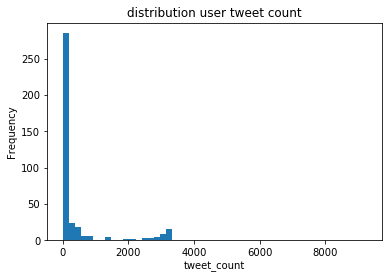

In [14]:
df_user.tweet_count.plot.hist(bins=50)
plt.title('distribution user tweet count')
plt.xlabel('tweet_count')
plt.show()

We can also modify the variable 'created_at' into a datetime.

In [9]:
df_user.created_at = pd.to_datetime(df_user.created_at)

In [10]:
# group time every day 
df = pd.DataFrame(df_user.groupby(df_user.created_at.dt.floor('1d')).size()).reset_index()

fig = go.Figure(go.Scatter(
    x = df['created_at'],
    y = df[0]
))

fig.show()

We see that the creation of twitter accounts stops several months before the US election, november 2016.

## Twetts dataset

In [17]:
df_twett

user_id         user_key    created_at          created_str  \
0       1.868981e+09    ryanmaxwell_1  1.458672e+12  2016-03-22 18:31:42   
1       2.571870e+09  detroitdailynew  1.476133e+12  2016-10-10 20:57:00   
2       1.710805e+09       cookncooks  1.487767e+12  2017-02-22 12:43:43   
3       2.584153e+09     queenofthewo  1.482765e+12  2016-12-26 15:06:41   
4       1.768260e+09     mrclydepratt  1.501987e+12  2017-08-06 02:36:24   
...              ...              ...           ...                  ...   
203477  1.518857e+09     nojonathonno  1.478002e+12  2016-11-01 12:13:06   
203478  2.587101e+09   judelambertusa  1.434589e+12  2015-06-18 01:04:35   
203479  2.671070e+09     patriotblake  1.484074e+12  2017-01-10 18:50:48   
203480  2.630842e+09    dailysandiego  1.479679e+12  2016-11-20 21:49:07   
203481  1.680366e+09    willisbonnerr  1.482188e+12  2016-12-19 23:00:17   

        retweet_count retweeted  favorite_count  \
0                 NaN       NaN             NaN   
1                 0.0     False             0.0   
2                 NaN       NaN             NaN   
3                 NaN       NaN             NaN   
4                 NaN       NaN             NaN   
...               ...       ...             ...   
203477            0.0     False             0.0   
203478            NaN       NaN             NaN   
203479            NaN       NaN             NaN   
203480            0.0     False             0.0   
203481            NaN       NaN             NaN   

                                                     text      tweet_id  \
0       #IslamKills Are you trying to say that there w...  7.123460e+17   
1       Clinton: Trump should’ve apologized more, atta...  7.855849e+17   
2       RT @ltapoll: Who was/is the best president of ...  8.343832e+17   
3       RT @jww372: I don't have to guess your religio...  8.134006e+17   
4       RT @Shareblue: Pence and his lawyers decided w...  8.940243e+17   
...                                                   ...           ...   
203477  RT @AndreaChalupa: In intel circles, the story...  7.934256e+17   
203478  RT @KansasCityDNews: Tonganoxie police: Middle...  6.113387e+17   
203479  RT @signsinyork: Getting the right #company lo...  8.188929e+17   
203480  The Latest: Obama affirms continuity of ties w...  8.004560e+17   
203481  RT @futureguru100: U cant just Upload a CD onl...  8.109831e+17   

                                                   source  \
0                                                     NaN   
1       <a href="http://twitterfeed.com" rel="nofollow...   
2                                                     NaN   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
203477  <a href="http://twitter.com" rel="nofollow">Tw...   
203478                                                NaN   
203479                                                NaN   
203480  <a href="http://twibble.io" rel="nofollow">Twi...   
203481                                                NaN   

                      hashtags  \
0               ["IslamKills"]   
1                           []   
2                           []   
3       ["ChristmasAftermath"]   
4                           []   
...                        ...   
203477                      []   
203478               ["local"]   
203479             ["company"]   
203480                      []   
203481                      []   

                                            expanded_urls  posted  \
0                                                      []  POSTED   
1                             ["http://detne.ws/2e172jF"]  POSTED   
2                                                      []  POSTED   
3                                                      []  POSTED   
4                                                      []  POSTED   
...                           

In [18]:
df_twett.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203482 entries, 0 to 203481
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                195417 non-null  float64
 1   user_key               203482 non-null  object 
 2   created_at             203461 non-null  float64
 3   created_str            203461 non-null  object 
 4   retweet_count          58083 non-null   float64
 5   retweeted              58083 non-null   object 
 6   favorite_count         58083 non-null   float64
 7   text                   203461 non-null  object 
 8   tweet_id               201168 non-null  float64
 9   source                 58084 non-null   object 
 10  hashtags               203482 non-null  object 
 11  expanded_urls          203482 non-null  object 
 12  posted                 203482 non-null  object 
 13  mentions               203482 non-null  object 
 14  retweeted_status_id    39651 non-nul

### NaN Values - features engineering

The treatements of NaN values the tweets dataframe will be different because for some of variables dealing with missing values is a modification of the variable.

#### Numeric and binary variables

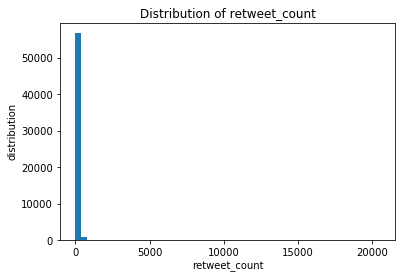

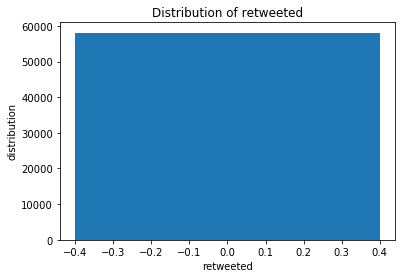

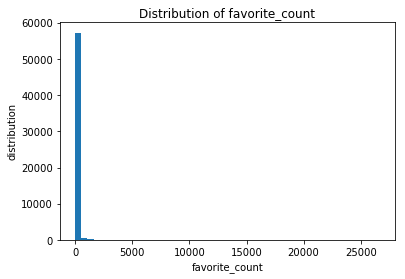

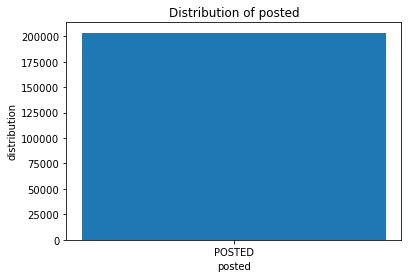

In [19]:
for var in ['retweet_count', 'retweeted', 'favorite_count', 'posted']:
    try:
        df_twett[var].plot.hist(bins=50)
        plt.title('Distribution of '+ var)
        plt.xlabel(var)
        plt.ylabel('distribution')
        plt.show()
    except:
        plt.bar(df_twett[var].value_counts(dropna=False).index.values,
                df_twett[var].value_counts(dropna=False).values)
        plt.title('Distribution of '+ var)
        plt.xlabel(var)
        plt.ylabel('distribution')
        plt.show()

##### retweet_count

In [20]:
df_twett.retweet_count.value_counts(dropna=False)

NaN       145399
0.0        47856
1.0         1436
2.0          405
3.0          207
           ...  
1219.0         1
1691.0         1
780.0          1
1964.0         1
608.0          1
Name: retweet_count, Length: 1230, dtype: int64

##### retweeted

In [21]:
df_twett.retweeted.value_counts(dropna=False)

NaN      145399
False     58083
Name: retweeted, dtype: int64

##### favorite_count

In [22]:
df_twett.favorite_count.value_counts(dropna=False)

NaN       145399
0.0        48839
1.0          631
2.0          333
3.0          197
           ...  
2545.0         1
1271.0         1
3565.0         1
633.0          1
1752.0         1
Name: favorite_count, Length: 1168, dtype: int64

##### posted

In [23]:
df_twett.posted.value_counts(dropna=False)

POSTED    203482
Name: posted, dtype: int64

##### relations 

In [24]:
df_twett[df_twett.retweet_count==0].retweeted.value_counts(dropna=False)/58083

False    0.823924
Name: retweeted, dtype: float64

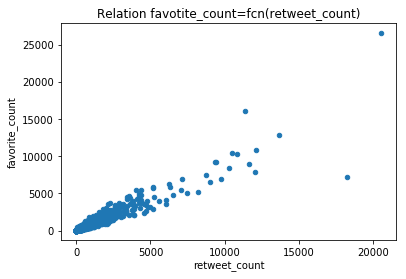

In [25]:
df_twett.plot.scatter('retweet_count','favorite_count')
plt.title('Relation favotite_count=fcn(retweet_count)')
plt.show()

We notice that:
1. the variables **'retweet_count'** and **'favorite_count'** have only **less than 60k values and more than 90% is equal to 0**. In addition their **relation is linear**.
2. the variable **'retweeted'** also have **less than 60k** and is **false when the retweet_count=0 for 82% (18% of the false appear when retweet_count>0 - seem weird)**.
3. The variable **'posted' can be drop**.

According these observations, we  modify the variable 'retweeted' according the value of 'retweet_count' by assigning:
1. if retweet_count=0, we have 0
2. if retweet_count>0, we have 1
3. if retweet_count is missing, we have -1


### df_tweets - features engineering

In [68]:
def func(v):
    """function transform the variables retweeted"""
    if np.isnan(v):
        return -1
    elif v==0:
        return 0
    else:
        return 1
    
df_twett.retweeted = df_twett.retweet_count.apply(lambda v: func(v))

In [12]:
def func(s, val_time):
    """extract year month day hour from the date"""
    try:
        date = datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
        if val_time=='hour':
            return date.hour
        elif val_time=='year':
            return date.year
        elif val_time=='day':
            return date.day
        elif val_time=='month':
            return date.month
        else:
            return date
    except:
        return s
    
df_twett['year'] = df_twett.created_str.apply(lambda s:  func(s, 'year'))
df_twett['month'] = df_twett.created_str.apply(lambda s:  func(s, 'month'))
df_twett['day'] = df_twett.created_str.apply(lambda s:  func(s, 'day'))
df_twett['hour'] = df_twett.created_str.apply(lambda s:  func(s, 'hour'))

df_twett.created_str = pd.to_datetime(df_twett.created_str)

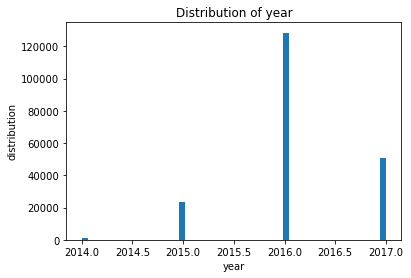

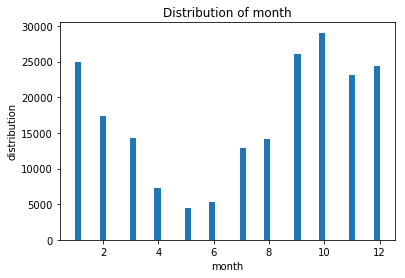

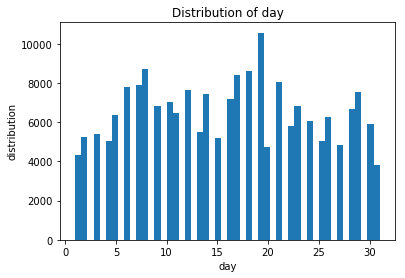

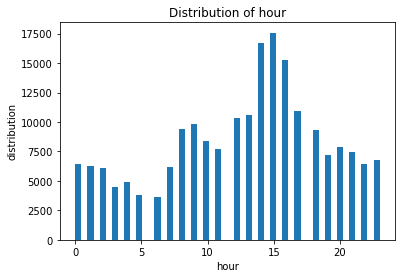

In [28]:
for var in ['year', 'month', 'day', 'hour']:
    
    df_twett[var].plot.hist(bins=50)
    plt.title('Distribution of '+ var)
    plt.xlabel(var)
    plt.ylabel('distribution')
    plt.show()

In [13]:
# group time every day 
df = pd.DataFrame(df_twett.groupby(df_twett.created_str.dt.floor('1d')).size()).reset_index()

fig = go.Figure(go.Scatter(
    x = df['created_str'],
    y = df[0]
))

fig.update_xaxes(
    rangeslider_visible=True,
    tickformatstops = [
        dict(dtickrange=[None, 1000], value="%H:%M:%S.%L ms"),
        dict(dtickrange=[1000, 60000], value="%H:%M:%S s"),
        dict(dtickrange=[60000, 3600000], value="%H:%M m"),
        dict(dtickrange=[3600000, 86400000], value="%H:%M h"),
        dict(dtickrange=[86400000, 604800000], value="%e. %b d"),
        dict(dtickrange=[604800000, "M1"], value="%e. %b w"),
        dict(dtickrange=["M1", "M12"], value="%b '%y M"),
        dict(dtickrange=["M12", None], value="%Y Y")
    ]
)

fig.show()

We notice that the most of the tweets was send around the election date. However, the activity starts several months before and continue little bit after.

In [14]:
# drop NaN texts
df_twett.dropna(subset=['text'], inplace=True)
df_twett.reset_index(inplace=True)
df_twett.drop(['index'], axis=1, inplace=True)

In [15]:
def func(t):
    return len(t.split())
df_twett['nb_words'] = df_twett.text.apply(lambda t:  func(t))

Text(0.5, 0, 'number of words')

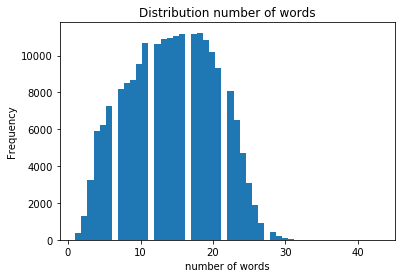

In [32]:
df_twett.nb_words.plot.hist(bins=50)
plt.title('Distribution number of words')
plt.xlabel('number of words')

# Twett Study

## Build Data 

Here we are going to build a dataset from text:
1. Clean the text from common words and stopwords
2. Extract hashtags from the text and count tem
3. Extract mentions from the text and count them
4. Extract url from the text and count them.

We also add data from the twett dataframe. According to the previous analysis I want to rebuild a dataframe cleaner.



In [17]:
def clean_text(s):
    """function cleans a text"""
    
    filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
#            gsp.stem_text
          ]
    
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s


def data_text_builder(df_twett):
    """functions wchich create a dataframe from df_twett to obtain a dataframe
    clean and focus on the text.
    """
    
    df = df_twett[~df_twett.user_id.isnull()]
    d = {}
    i = 0
    for index, row in df.iterrows():
        d[str(i)] = {}
        
        t = row['text']
        idd = row['user_id']
        y = row['year']
        m = row['month']
        da = row['day']
        h = row['hour']
        
        hashtags = re.findall(r"(#\w*)", t)
        mentions = re.findall(r"(@\w*)", t)
        urls = re.findall(r'http\S+', t)

        t = re.sub(r'http\S+', '', t)
        t = re.sub(r'(#\w*)', '', t)
        t = re.sub(r'(@\w*)', '', t)

        clean_t = clean_text(t)
        d[str(i)]['uid'] = idd
        d[str(i)]['text'] = clean_t
        d[str(i)]['nb_words'] = len(clean_t.split())
        d[str(i)]['hashtags'] = hashtags
        d[str(i)]['nb_hashtags'] = len(hashtags)
        d[str(i)]['mentions'] = mentions
        d[str(i)]['nb_mentions'] = len(mentions)
        d[str(i)]['urls'] = urls
        d[str(i)]['nb_urls'] = len(urls)
        d[str(i)]['year'] = y
        d[str(i)]['month'] = m
        d[str(i)]['day'] = da
        d[str(i)]['hour'] = h

        i = i +1
    return pd.DataFrame(d).T


In [18]:
# build the new dataframe
df_text = data_text_builder(df_twett)

In [35]:
df_text.head()

uid                                               text  \
0       1.86898e+09       trying terrorist attacks europe refugees let   
1       2.57187e+09        clinton trump should’ve apologized attacked   
2        1.7108e+09         best president past years vote amp retweet   
3       2.58415e+09                                     guess religion   
4       1.76826e+09       pence lawyers decided official emails public   
...             ...                                                ...   
195391  1.51886e+09  intel circles story goes fsb filmed trump orgy...   
195392   2.5871e+09  tonganoxie police middle school girl sexually ...   
195393  2.67107e+09                     getting right logo got message   
195394  2.63084e+09        latest obama affirms continuity ties canada   
195395  1.68037e+09  upload online amp thats product work gotta rep...   

       nb_words                 hashtags nb_hashtags  \
0             6            [#IslamKills]           1   
1             5                       []           0   
2             7                       []           0   
3             2    [#ChristmasAftermath]           1   
4             6                       []           0   
...         ...                      ...         ...   
195391       15                       []           0   
195392        8                 [#local]           1   
195393        5  [#company, #businesses]           2   
195394        6                       []           0   
195395       11                       []           0   

                                mentions nb_mentions  \
0                                     []           0   
1                                     []           0   
2                             [@ltapoll]           1   
3                              [@jww372]           1   
4           [@Shareblue, @alisonrose711]           2   
...                                  ...         ...   
195391                  [@AndreaChalupa]           1   
195392                [@KansasCityDNews]           1   
195393  [@signsinyork, @smallbusinessuk]           2   
195394                                []           0   
195395                  [@futureguru100]           1   

                                                     urls nb_urls  year month  \
0                                                      []       0  2016     3   
1                               [https://t.co/eJampkoHFZ]       1  2016    10   
2                                                      []       0  2017     2   
3                                                      []       0  2016    12   
4                               [https://t.co/HjhPguBK1Y]       1  2017     8   
...                                                   ...     ...   ...   ...   
195391                                                 []       0  2016    11   
195392                                                 []       0  2015     6   
195393                          [https://t.co/Fnse5GA6DC]       1  2017     1   
195394  [https://t.co/q4bZnWXdSS, https://t.co/GPy8dGK...       2  2016    11   
195395                                                 []       0  2016    12   

       day hour  
0       22   18  
1       10   20  
2       22   12  
3       26   15  
4        6    2  
...     ..  ...  
195391   1   12  
195392  18    1  
195393  10   18  
195394  20   21  
195395  19   23  

[195396 rows x 13 columns]

## EDA

In [26]:
corpus = df_text.text.values.tolist()

### Words and Hashtags Frequency

We focus on words and hashtags frequency:
1. The total frequency of a word
2. The unique frequency of a word (count only 1)
3. The frequency of hashtags

In [21]:
# compute frequncies 
def words_freq(corpus):
    """Store frequency of each word into a dictionnary
    sorted according the frequency
    params:
    - corpus : list of documents
    return:
    a sorted dictionnary
    """
    counter = Counter(' '.join(corpus).split())
    d = {}
    for word, freq in counter.most_common():
        d[word] = freq
    return d


def corpus_freq(corpus):
    """Store unique frequency of each word into a dictionnary
    sorted according the frequency
    params:
    - corpus : list of documents
    return:
    a sorted dictionnary
    """
    d = {} 
    for txt in corpus:
        words = set(txt.split())
        for w in words:
            if not w in d.keys():
                d[w] = 1
            else:
                d[w] += 1
    return dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

#### Words

In [16]:
d_freq = words_freq(corpus)
d_ufreq = corpus_freq(corpus)

In [39]:
fig = go.Figure()
n = 100

for label in ['freq', 'unique_freq']:
    
    if label=='freq':
        words = list(d_freq.keys())[:n]
        freq = list(d_freq.values())[:n]
    elif label=='unique_freq':
        words = list(d_ufreq.keys())[:n]
        freq = list(d_ufreq.values())[:n]

    fig.add_trace(go.Bar(x=words,
                       y=freq,
                       name=label))

fig.update_layout(barmode='stack')
fig.show()

First of all we notice that the **frequencies and unique frequencies are quite the same for a specific word**, why, because is Twitter... In fact the tweets are small so there is a few repitition of words in the same text. That information allow us to prefer BOW than TFIDF for any count representation.

Then, the most common word is TRUMP and we can understand that the main topics are politics for the US election and the newspapers.

#### Hashtags

In [19]:
list_hashtags = []
for lh in df_text.hashtags:
    if len(lh)>0:
        for h in lh:
            list_hashtags.append(h.lower())

In [22]:
fig = go.Figure()
n = 200

d_hfreq = words_freq(list_hashtags)

words = list(d_hfreq.keys())[:n]
freq = list(d_hfreq.values())[:n]


fig.add_trace(go.Bar(x=words,
                       y=freq))

fig.update_layout()
fig.show()



Once more with the hashtags, we notice that poilitics is the main topics in with trump and newspaper (pjnet).

We create a new variable which resume by a value the importance of hashtags used in a text. For each hashtag used in a text, we compute the mean of the hashtag occurence. Thus more a text used frequent hashtags more the score is high. We may say it is a way to embedd the hashtags.

In [23]:
res = []
for lh in df_text.hashtags:
    if len(lh)==0:
        res.append(0)
    else:
        v = 0
        for h in lh:
            h = h.lower()
            v = v + d_hfreq[h]
        res.append(v/len(h))
        
df_text['xr_hashtags'] = res

### Numerical values

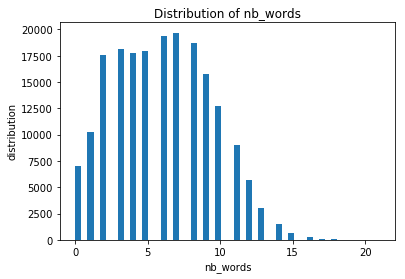

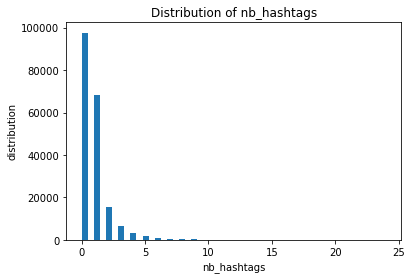

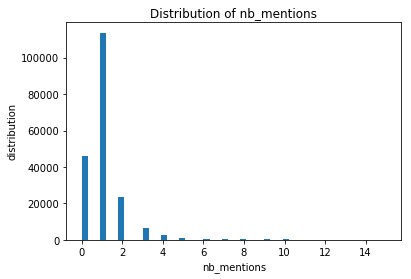

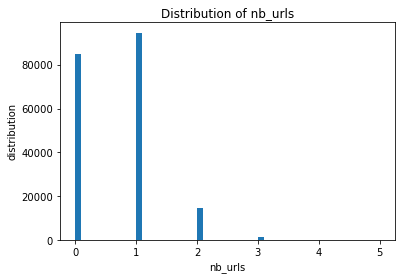

In [43]:
for var in ['nb_words', 'nb_hashtags', 'nb_mentions', 'nb_urls']:
    
    df_text[var].plot.hist(bins=50)
    plt.title('Distribution of '+ var)
    plt.xlabel(var)
    plt.ylabel('distribution')
    plt.show()

## Text Topics


In this part we are going to **model the topics** of the corpus of twetts. We are using the Bag Of Word representation then the LDA algorithm.

The BOW convert a collection of text documents to a matrix of token counts, it results the sparse matrix with dimension (nb of documents, vocabulary). 

The latent Dirichlet allocation (LDA algorithm) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. If observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.

We are using a samples of 30k documents randomely selected and a vocabulary of 1000 most common words.

In [28]:
n_samples = 30000
n_features = 1000
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    """function which print the topics from topics modelling model
    params:
    -model : topic model
    -feature_name : vocabulary used
    - n_top_words : number of word to print 
    """
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [29]:
random.shuffle(corpus)
corpus_samples =corpus[:n_samples]

In [30]:

# Use tf (raw term count) features.

tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(corpus_samples)


In [31]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=15, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model with tf:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Fitting LDA models with tf features, n_samples=30000 and n_features=1000...
done in 17.371s.

Topics in LDA model with tf:
Topic #0: man tell work wants calls talk home times isn john
Topic #1: time country best getting person usa friends story und shot
Topic #2: obama says trump today got hillary fbi emails morning wikileaks
Topic #3: watch gop national ht job called feel new run political
Topic #4: news world real post breaking big left change gun sure
Topic #5: new think campaign stop woman muslim war refugees thank truth
Topic #6: america media women great police old come told kill liberals
Topic #7: trump donald vote want election going won said god live
Topic #8: amp people trump let need money anti family americans supporters
Topic #9: love way believe die hate poll cnn long lost playing
Topic #10: black day white good dnc fight pay music join lives
Topic #11: president trump life look htt voting makes check actually security
Topic #12: like house million remember end lol true g

In [66]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14     114.344879  114.308296       1        1  10.529180
7      105.821045  -93.749626       2        1  10.378236
8     -138.334473   95.320763       3        1   9.594560
2       -7.436697  111.259697       4        1   7.409787
5     -207.550629 -105.472603       5        1   6.566433
11      52.817650   14.603765       6        1   6.211009
10     168.010849    6.806950       7        1   6.146130
6      -94.169601 -157.789551       8        1   6.038630
4     -122.849174  -39.059418       9        1   5.767524
12     -94.894264  195.408295      10        1   5.453769
0       24.927401 -180.464874      11        1   5.361993
1      -53.413467   26.832108      12        1   5.307917
13     -12.255850  -72.093201      13        1   5.307575
9     -224.217957   28.070581      14        1   5.225259
3       36.154255  209.427582      15        1   4.701998, topic_info=        Term         Freq        Total Category  logprob  loglift
155  clinton  1764.000000  1764.000000  Default  30.0000  30.0000
911    trump  4122.000000  4122.000000  Default  29.0000  29.0000
611    obama  1320.000000  1320.000000  Default  28.0000  28.0000
33       amp  1466.000000  1466.000000  Default  27.0000  27.0000
404  hillary  1579.000000  1579.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
605      non    58.849340    59.784980  Topic15  -4.3402   3.0414
476     lady    57.434178    58.369818  Topic15  -4.3645   3.0410
608  nuclear    49.669146    50.604786  Topic15  -4.5098   3.0385
472     knew    48.931336    49.866977  Topic15  -4.5247   3.0382
599      new   149.873107   799.137159  Topic15  -3.4054   1.3834

[499 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6         8  0.983402       act
9         6  0.995334  actually
15        8  0.991686   african
18        1  0.984211       ago
19       13  0.983798     agree
...     ...       ...       ...
992       1  0.997875      year
993       1  0.996411     years
994       2  0.996418       yes
996      15  0.984754      york
997      14  0.994144     young

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 8, 9, 3, 6, 12, 11, 7, 5, 13, 1, 2, 14, 10, 4])

We obtain 15 topics well separeted. The choice of 15 topics is done after running several time with different value of number of components. 15 topics give:
1. well seperated clusters 
2. balance representation
3. cross topics which (for example the word trump and hilary)

However this choice is an assumption, 30 topics can be also interesting but gives clusters of small size. In an other hand a number of 50 topics will gives small clusters close to each other, which can be aggregated together.

## Texts Type Visualization


From here we combine all the features created from the begining for each text:
1. 'nb_words', 
2. 'nb_hashtags', 
2. 'nb_mentions', 
2. 'nb_urls', 
2. 'topic', 
2. 'xr_hashtags',
2. 'year', 
2. 'month', 
2. 'day', 
2. 'hour'

Then the data we apply a PCA reduction for plotting in sample and vizualize the behavior of each features according to the principal components. Somehow we are doing a feature importance and understand (visually for now) what are the features which categorize a fake tweet.

In [32]:
v = tf_vectorizer.transform(corpus)
df_text['topic'] = np.argmax(lda.transform(v), axis=1)

In [33]:
list_var = ['nb_words', 'nb_hashtags', 'nb_mentions', 'nb_urls', 'topic', 'xr_hashtags',
                      'year', 'month', 'day', 'hour']

In [35]:
X_scale = StandardScaler().fit_transform(df_text[list_var].values)

In [36]:
X_pca = PCA(2).fit_transform(X_scale)

In [37]:
df_text['pc0'] = X_pca[:,0]
df_text['pc1'] = X_pca[:,1]

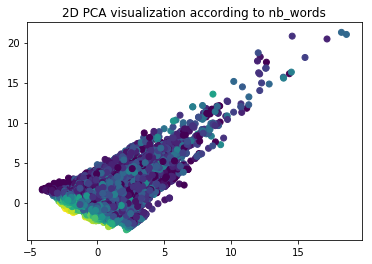

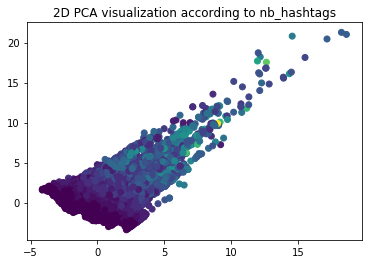

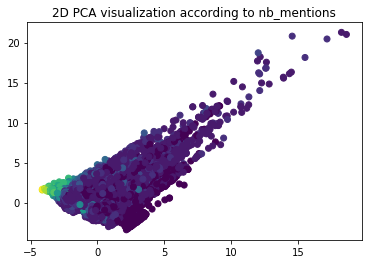

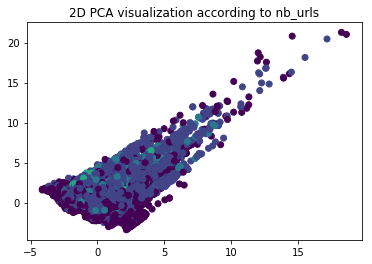

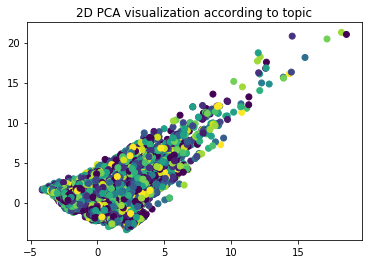

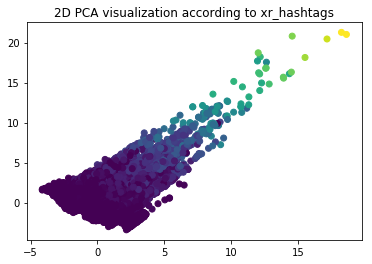

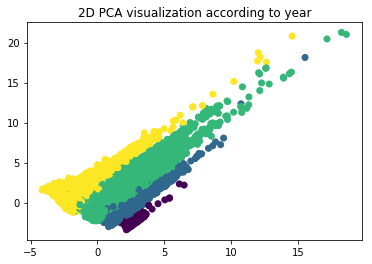

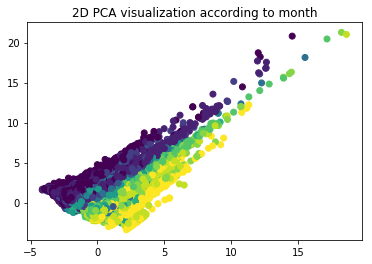

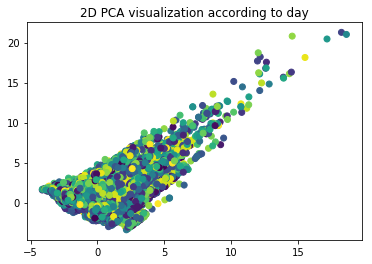

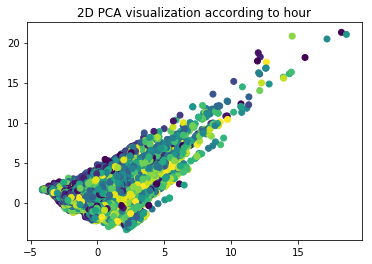

In [33]:
for var in ['nb_words', 'nb_hashtags', 'nb_mentions', 'nb_urls', 'topic', 'xr_hashtags','year', 'month', 'day', 'hour']:
    plt.scatter(df_text['pc0'], df_text['pc1'], c=df_text[var])
    plt.title('2D PCA visualization according to '+var)
    plt.show()

We notice easily that the features **'hour' and 'day' don't participate in the representation** and the variable **'topic'** also which can mean that the **text doesn't really help to identify fake tweets** or **this solution doesn't allow to see the importance of the variable**.

What is interesting is the representation of the variable **'xr_hashtags'** (mean of the occurence of the hashtags used in a text) we really see how this **variable increase** and **put the samples in the upper right corner**. An assumption can be taken, the variable **'xr_hashtags' can show how a fake tweet can be hard to detect** because it rely on very popular hashtags used in may other documents and create a community of information. We remember also that the hashtag 'pjnet' (public journalist network).

# Profile Study 

In this chapter we try to understand how the information about an account can help us to identify fake tweets.

The process will be the same than before however by joining the dataframe we can observe the representation of the data according the features of the user.

In [38]:
df_profile = df_text.merge(df_user, left_on='uid', right_on='id')

In [67]:
df_profile.columns

Index(['uid', 'text', 'nb_words', 'hashtags', 'nb_hashtags', 'mentions',
       'nb_mentions', 'urls', 'nb_urls', 'year', 'month', 'day', 'hour',
       'xr_hashtags', 'topic', 'pc0', 'pc1', 'id', 'location', 'name',
       'followers_count', 'statuses_count', 'time_zone', 'lang', 'screen_name',
       'description', 'created_at', 'favourites_count', 'friends_count',
       'listed_count', 'tweet_count'],
      dtype='object')

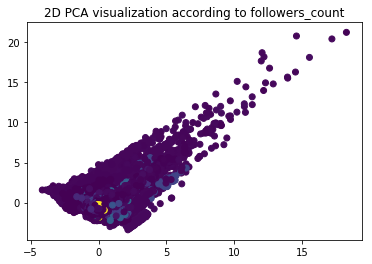

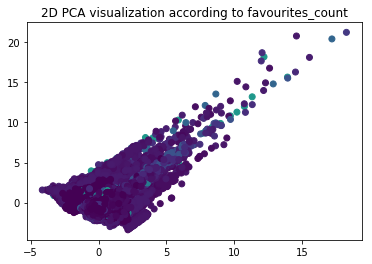

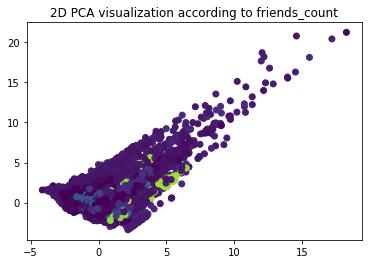

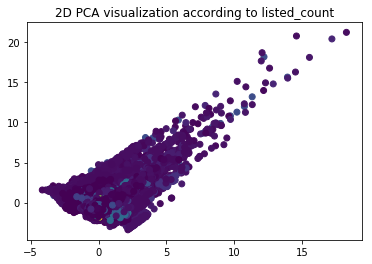

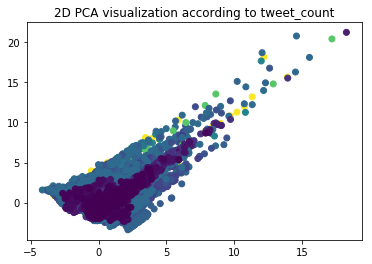

In [42]:
for var in ['followers_count','favourites_count', 'friends_count', 'listed_count', 'tweet_count']:
    x = df_profile.drop_duplicates(subset=['text'])['pc0']
    y = df_profile.drop_duplicates(subset=['text'])['pc1']
    colors = df_profile.drop_duplicates(subset=['text'])[var]
    plt.scatter(x, y, c=colors)
    plt.title('2D PCA visualization according to '+var)
    plt.show()

We notice here that the variable **'tweet_count'** affect the most the representation.

# Network

We are going to visualize the network of user for documents use very popular hashtags.

In [54]:
df_network = df_profile[df_profile.xr_hashtags>=3000][['screen_name', 'mentions']]

In [55]:
def func(l):
    """
    params: list of strings
    function returns 'none' if the length = 0
    or the first string.
    """
    if len(l)==0:
        return 'none'
    else:
        return l[0][1:]
df_network.mentions = df_network.mentions.apply(lambda l: func(l))

In [56]:
df_network = df_network[df_network.mentions!='none']

In [57]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df_network, 'screen_name', 'mentions')
adj = nx.adjacency_matrix(G)

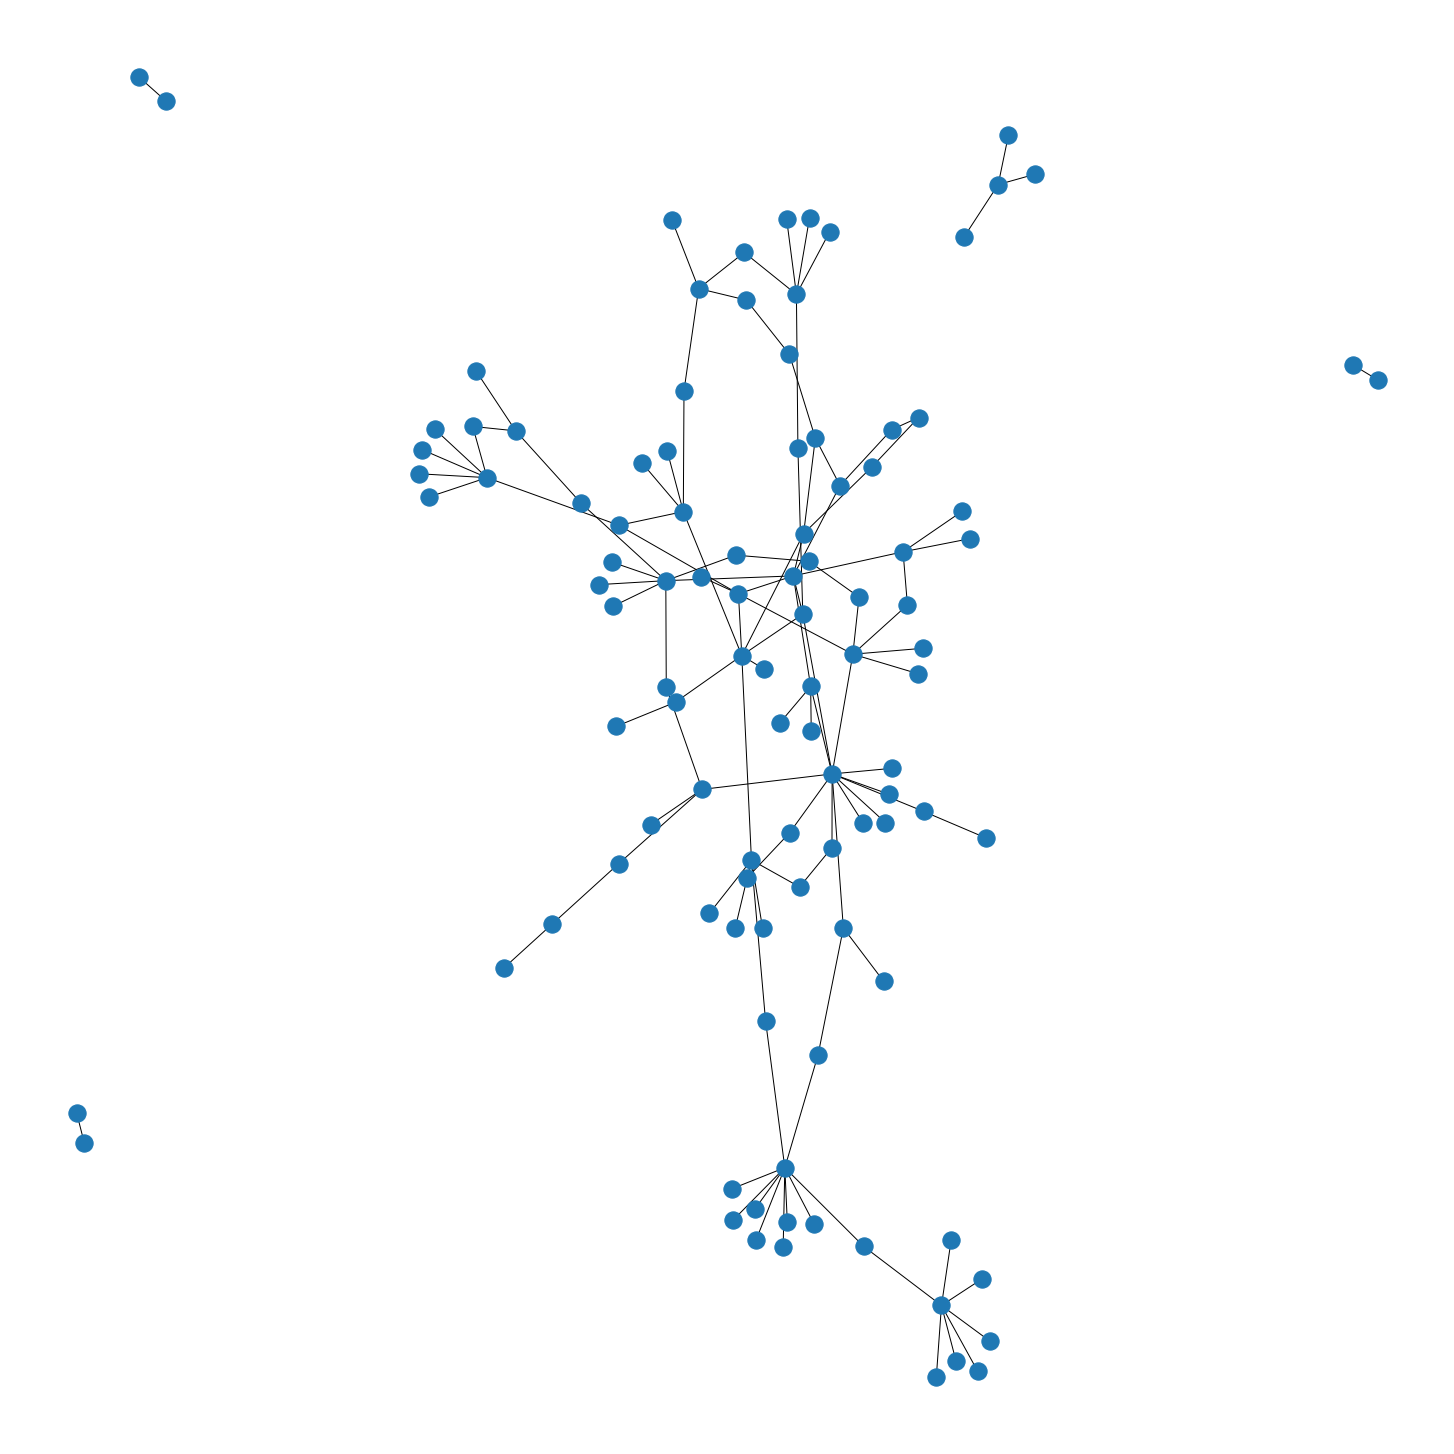

In [65]:
fig=plt.figure(figsize=(20,20))
nx.draw(G)
plt.show()

# Summary

**About the data**

We have data with many missing values and a better understanding about how the data is extract can help us to deal with them and came up with a better to fill them. 

The EDA part shows expected behaviors but the creations of accounts appears several months before the US elections. I was expecting very short amount of time between the creation of a fake account and the fake tweets.

**Topic Modelling**

The topics given by the LDA model fit well the subjects of the US Election (in my opinion), however the next part show us that the topics (even text) are not enough to understand the pattern of a fake tweets. 

In my opinion, the better way to undertand a fake tweet via the text is to build a neural network classifier with true tweets, a solution which doesn't need to clean the text and keep the full context of each sentence (transfer learning with BERT)

**Caracterization of fake tweets**

To understand the pattern o fake tweets, we selected features that caracterize each texts and reduce the dimension with PCA. PCA will create principal components which are linear relations with the original features. Thus analyse how the representation changes with the original variables help us to identify the most relevant features (features importance).

That solution shows that the variable 'xr_hashtags' and 'tweet_count' are the best features to caracterize a fake tweet. In fact we can assume that a fake tweet will be harder to detect if it uses very popular hashtags and the fake account has tendency to send a lot of tweets.

**Network**

The network draw by the data shows that tweets are relay a few. We can assume that fake tweets don't find easily their audiance because the mentions don't follow up, don't share to others.


**Conclusion**

Is seems complicated to finb a significative pattern of a fake tweets. Somehow, it s like to be a very good liar which hide behind good caracteristics as number of tweet, popular hashtags and talking about important topic. 
